
Panorama images classification
==============================
(resnet18 transfer learning)
============================




In [2]:
%matplotlib inline

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
    accuracy_score, precision_score, recall_score, f1_score
from IPython.display import clear_output

plt.ion()   # interactive mode

#Mounting Google Drive data
from google.colab import drive
drive.mount('/content/gdrive')

#Use GPU device
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Used device:", device)

Mounted at /content/gdrive
Used device: cuda


# Resnet18 hyperparameter setting

In [ ]:
# Learning rate
learning_rate = 0.01 # 0.01 0.001 0.0001

# Momentum
moment = 0.9

# Number of epochs for training
nEpochs = 30

# Finetuning batch size
batch_size = 64

# Step size in the learning rate decay
lr_dec_step_size = 7

# Factor that must be multiplied by the actual learning rate, in the
# lerning rate decay, after "lr_dec_step_size" steps have passed
lr_dec_gamma = 0.1

# Specify paths

In [5]:
# Root directory of interest
gdrivePath = F"gdrive/MyDrive/ML_AI" # where to save accuracies, losses and model checkpoints (csv)

# Dataset to use
data_dir = gdrivePath + "/NatureDatasetNew"

# Directory in which model checkpoints (for each epoch) are saved
modelCheckpointPath = os.path.join(gdrivePath,"modelCheckpoints/resnet")

# Directory where csv files collecting accuracy and loss values (for both
# training and testing) are saved
csvLogs_path = os.path.join(gdrivePath, r"csvLogs/resnet/")

# String to be attached to folder and file names, to specify the values of the
# learning rate and number of epochs used
actualParams = "_LR("+str(learning_rate).replace(".","_")+")_nEpochs(" + str(nEpochs) + ")"

# Folder in which best model checkpoint and metrics are saved
savingMetricsPath = gdrivePath + "/CNN_finalMetrics/resnet/resnet18" + actualParams

# csv file where are saved the accuracy on the train set versus the accuracy
# obtained in the test set (the second one for the loss)
csv_acc_path = os.path.join(csvLogs_path,"train_test_accuracy.csv")
csv_loss_path = os.path.join(csvLogs_path,"train_test_loss.csv")

# Path of the ENTIRE TEST to compute evaluation metrics of best model
finalTestPath = gdrivePath + "/NatureDataset/test"
#finalTestPath = gdrivePath + "/NatureDatasetNew/test"
#finalTestPath = gdrivePath + "/NatureDatasetReduced/test"

paths = [gdrivePath, data_dir, modelCheckpointPath, csvLogs_path, savingMetricsPath, finalTestPath]

for path in paths:
    if not os.path.exists(path):
        print( "Directory {:s} does not exist!".format(path) )
        createIt = '0'
        while createIt!='y' and createIt!='n':
            createIt = input("Do you want to create it ([y] or [n])? ")
        if createIt=='y':
            os.makedirs(path)
            print("Directory {:s} created".format(path) )
            

NameError: ignored

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

There are 50 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

print("Number of images in the 'train' dataset: " + str(dataset_sizes['train']))
print("Number of images in the 'test' dataset: " + str(dataset_sizes['test']))
print("Class names: " + str(class_names) )

Number of images in the 'train' dataset: 600
Number of images in the 'test' dataset: 900
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Just a simple visualization of few images, with their respective classes
------------------------------------------------------------------------
`imshow(inp, title=None)`



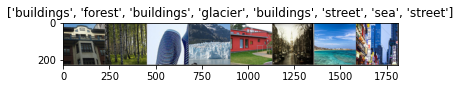

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# (Maximum) Number of images to show (to avoid too small images)
if len(inputs)>10:
    nImagesToShow = 8
else:
    nImagesToShow = len(inputs)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:nImagesToShow])

imshow(out, title=[class_names[x] for x in classes[:nImagesToShow]])

Training the model
------------------

A general function to train a model.

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Variables in which metrics are saved, for each epoch
    train_loss = []; train_accuracy = []; test_loss = []; test_accuracy = []
    test_precision = []; test_recall = []; test_f1score = []; test_conf_matrix = [];
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and testing phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Save losses and accuracies
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_accuracy.append(epoch_acc.to('cpu').numpy())
            else: # phase == 'test'
                test_loss.append(epoch_loss)
                test_accuracy.append(epoch_acc.to('cpu').numpy())
            
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save and mark best model
                # COMMENT THE FOLLOWING LINE IF YOU DON'T WANT TO SAVE THE (BEST) MODEL
                torch.save(model.state_dict(), os.path.join(savingMetricsPath, "resnet18_best"+actualParams+".pth"))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    #Save train losses and accuracies
    df_acc = pd.DataFrame(list(zip(train_accuracy, test_accuracy)), columns =['Train Accuracy', 'Test Accuracy'])
    df_loss = pd.DataFrame(list(zip(train_loss, test_loss)), columns =['Train Loss', 'Test Loss'])

    #Save test losses and accuracies
    df_acc.to_csv(os.path.join(csvLogs_path,"train_test_accuracy.csv"), index=False)
    df_loss.to_csv(os.path.join(csvLogs_path,"train_test_loss.csv"), index=False)
    print("""All train/test accuracies and losses have been written on the .csv
        files in folder: """+str(csvLogs_path))
    
    return model # model with the best accuracy

Visualizing the model predictions
---------------------------------
Generic function to display predictions for a few images

`visualize_model(model, num_images=6)`




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model = models.resnet18(pretrained=True)
# Modify the output layer, to adapt it to our classification problem
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=moment)

# Finetuning learning_rate decay ###############################################
# Decay LR by a factor of "lr_dec_gamma" every "lr_dec_step_size" epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_dec_step_size, gamma=lr_dec_gamma)
################################################################################

Train and evaluate
------------------




In [ ]:
model_best = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=nEpochs)

Epoch 0/29
----------
train Loss: 1.2280 Acc: 0.5283
test Loss: 0.5915 Acc: 0.7822

Epoch 1/29
----------
train Loss: 0.4523 Acc: 0.8300
test Loss: 0.6229 Acc: 0.7967

Epoch 2/29
----------
train Loss: 0.3782 Acc: 0.8467
test Loss: 0.6252 Acc: 0.8100

Epoch 3/29
----------
train Loss: 0.3973 Acc: 0.8517
test Loss: 0.5495 Acc: 0.8244

Epoch 4/29
----------
train Loss: 0.3184 Acc: 0.8817
test Loss: 0.6739 Acc: 0.8000

Epoch 5/29
----------
train Loss: 0.4312 Acc: 0.8600
test Loss: 0.6476 Acc: 0.8144

Epoch 6/29
----------
train Loss: 0.3055 Acc: 0.9017
test Loss: 0.4380 Acc: 0.8456

Epoch 7/29
----------
train Loss: 0.2178 Acc: 0.9200
test Loss: 0.3935 Acc: 0.8689

Epoch 8/29
----------
train Loss: 0.2359 Acc: 0.9067
test Loss: 0.3610 Acc: 0.8833

Epoch 9/29
----------
train Loss: 0.1930 Acc: 0.9367
test Loss: 0.3545 Acc: 0.8811

Epoch 10/29
----------
train Loss: 0.1664 Acc: 0.9333
test Loss: 0.3471 Acc: 0.8878

Epoch 11/29
----------
train Loss: 0.1971 Acc: 0.9350
test Loss: 0.3436 Acc

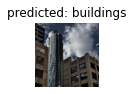

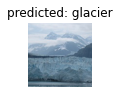

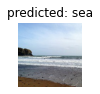

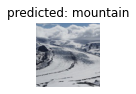

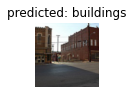

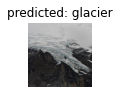

In [ ]:
visualize_model(model_best)

Function to plot accuracies vs losses during the training

<Figure size 432x288 with 0 Axes>

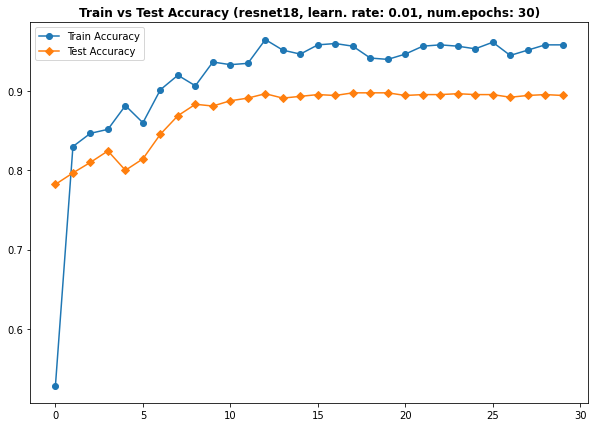

<Figure size 432x288 with 0 Axes>

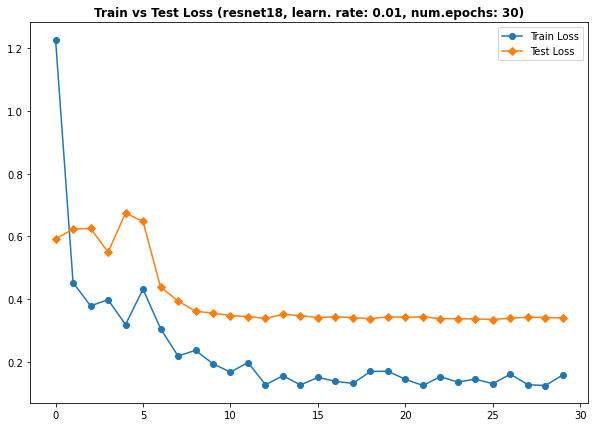

In [ ]:
def plot_acc_loss_trends(csv_acc_path, csv_loss_path):
    df_loss = pd.read_csv(csv_loss_path)
    df_accuracy = pd.read_csv(csv_acc_path)

    plt.figure(); ax = df_accuracy.plot(figsize=(10, 7));
    plt.title("Train vs Test Accuracy (resnet18, learn. rate: "+str(learning_rate)+", num.epochs: "+str(nEpochs)+")", fontweight='bold')
    markers = ['o','D']
    for i, line in enumerate(ax.get_lines()):
        line.set_marker(markers[i])
        plt.legend(loc='best')
    # Save this figure
    plt.savefig(savingMetricsPath+"/train_vs_test_ACC"+actualParams+".jpg")

    plt.figure(); ax = df_loss.plot(figsize=(10, 7));
    plt.title("Train vs Test Loss (resnet18, learn. rate: "+str(learning_rate)+", num.epochs: "+str(nEpochs)+")", fontweight='bold')
    for i, line in enumerate(ax.get_lines()):
        line.set_marker(markers[i])
        plt.legend(loc='best')
    # Save this figure
    plt.savefig(savingMetricsPath+"/train_vs_test_LOSS"+actualParams+".jpg")

plot_acc_loss_trends(csv_acc_path, csv_loss_path)

# Confusion Matrix computation

Function to compute, plot and save the confusion matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap= 'viridis',
                          saving_path=None):
    """
    This function plots and returns the confusion matrix.
    It also returns the figure handler, as second output.
    Normalization (rows) can be applied by setting `normalize=True`.
    cmap choices: 'plt.cm.Blues', 'inferno', 'viridis', 'cividis'
    """
    
    conf_matrix = confusion_matrix(y_true, y_pred) # Compute confusion matrix
   
    # Normalization along rows
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10,7))
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')# Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")# Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    
    return [conf_matrix, fig]

# Function to compute metrics values
for a given model evaluated on a specific dataloader

In [ ]:
def compute_metrics(model, dataloader, device, save=True):

    # Initialize the prediction and label lists(tensors)
    predictions_list = torch.zeros(0, dtype=torch.long, device='cpu')
    labels_list = torch.zeros(0, dtype=torch.long, device='cpu')

    # Disabling gradient calculation, useful to reduce memory consumption for
    # computations that would otherwise have requires_grad=True
    with torch.no_grad():
        print("Predicting labels...")
        for i, (inputs, classes) in enumerate(dataloader):
            since = time.time()
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs) # compute probabilities about "inputs" images batch, of belonging to each class
            _, preds = torch.max(outputs, 1) # preds -> class (indeces) with the hghest value (for the single image)
            # preds: index of the maximum element inside outputs tensor

            # Append batch prediction results
            predictions_list = torch.cat([predictions_list, preds.view(-1).cpu()])
            labels_list = torch.cat([labels_list, classes.view(-1).cpu()])
            # .view(-1) reshape to row vector
            time_elapsed = time.time() - since
            print("Batch n. {:d}/{:d} ({:.0f}m {:.0f}s)".format(i+1,len(dataloader),time_elapsed // 60, time_elapsed % 60))

    true_labels = labels_list.numpy()
    pred_labels = predictions_list.numpy()

    print("Computing metrics on true/predicted labels...",end="")
    # Accuracy, Precision, Recall, f1-score and Confusion Matrix for the model
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='macro')
    f1score = f1_score(true_labels, pred_labels, average='macro')

    conf_mat,fig = plot_confusion_matrix(true_labels, pred_labels,
        classes=class_names,
        title='resnet18, learning rate: '+str(learning_rate)+', num. epochs: '+str(nEpochs))

    classes_accuracy = conf_mat.diagonal()/conf_mat.sum(1)
    print("END")
    time.sleep(1) # Sleep for 1 second
    clear_output(wait=True)# Clear printed things up to now
    # Per-class accuracy
    i = 0
    str_acc_per_class = "Per-class accuracy:\n"
    for class_name in class_names:
        str_acc_per_class = str_acc_per_class +"{:s}: {:.2f} %".format(class_name, 100*classes_accuracy[i])+" | "
        i += 1
    #print(str_acc_per_class,end="\n\n")

    metrics_str = """resnet18: all layers trained
----------------------------------------------------------------------------
learning rate={:f}, num. epochs={:d}, momentum={:f}
Learning rate decay: step size={:d}, gamma={:f}
----------------------------------------------------------------------------
accuracy = {:f}, precision = {:f}, recall = {:f}, f1-score = {:f}""".format(\
        learning_rate,nEpochs,moment,lr_dec_step_size,lr_dec_gamma,\
        acc, prec, recall, f1score)
    
    metrics_str = metrics_str + "\n\n" + str_acc_per_class

    print(metrics_str)
    print("\n\n")

    metrics_csv = """learning rate;nEpochs;accuracy;precision;recall;f1-score\n{:f};{:f};{:f};{:f};{:f};{:f}""".format(learning_rate,nEpochs,acc, prec, recall, f1score)
    
    
    if save:
        # Save "metrics_str" to file
        file_path = savingMetricsPath+"/metrics"+actualParams+".txt"
        text_file = open(file_path, "w")
        text_file.write(metrics_str)
        text_file.close()

        # Save metrics as a "csv" ordered file
        file_path = savingMetricsPath+"/metrics"+actualParams+".csv"
        text_file = open(file_path, "w")
        text_file.write(metrics_csv)
        text_file.close()

        # Save confusion matrix
        plt.savefig(savingMetricsPath+"/conf_matrix"+actualParams+".jpg")

  


# Final **TEST** phase: metrics computation

Entire test dataset loading

In [ ]:
# Just normalization for validation
final_test_data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

final_test_image_datasets = datasets.ImageFolder(finalTestPath, final_test_data_transforms['test'])

if str(device)=='cpu':
    batch_size = 200
else:
    batch_size = 128
print("Batch size: ", batch_size)

finaltestdataloaders = torch.utils.data.DataLoader(final_test_image_datasets, batch_size=batch_size,
                                             shuffle=True, num_workers=2)
class_names = final_test_image_datasets.classes

print("Device: ", device)
print("Number of images in the entire 'test' dataset: " + str(len(final_test_image_datasets)))
print("Class names: " + str(class_names) )


Batch size:  128
Device:  cuda
Number of images in the entire 'test' dataset: 3000
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


resnet18: all layers trained
----------------------------------------------------------------------------
learning rate=0.010000, num. epochs=30, momentum=0.900000
Learning rate decay: step size=7, gamma=0.100000
----------------------------------------------------------------------------
accuracy = 0.889000, precision = 0.891937, recall = 0.890078, f1-score = 0.890559

Per-class accuracy:
buildings: 84.44 % | forest: 98.31 % | glacier: 84.81 % | mountain: 81.14 % | sea: 93.73 % | street: 91.62 % | 





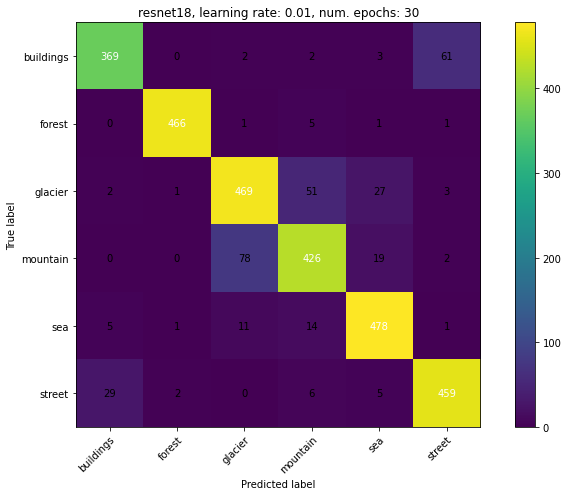

In [ ]:
# Load best model
finalModel = models.resnet18() # Load an "empty" model

num_ftrs = finalModel.fc.in_features
finalModel.fc = nn.Linear(num_ftrs, len(class_names))
finalModel = finalModel.to(device)
model_best_path = os.path.join(savingMetricsPath, "resnet18_best"+actualParams+".pth")

# Overwrite the "empty" model with the trained one (its dictionary)
finalModel.load_state_dict(torch.load(model_best_path, map_location=torch.device(device.type)))
finalModel.eval();

# Compute metrics related to this loaded best model
compute_metrics(finalModel, finaltestdataloaders, device, save=True)

# Plot accuracy, precision, recall, f1-score AGAINST learning rate


In [7]:
def create_4bars_chart(rangeX, dataY_1, dataY_2, dataY_3, dataY_4, labelsY, savingName, title, plotLabelX, plotLabelY):

    savingPath = ""
    barWidth = 0.2
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set position of bar on X axis
    br1 = np.arange(len(dataY_1))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]

    # Make the plot
    plt.bar(br1, dataY_1, color=(0.533, 0.67, 0.81), width=barWidth, edgecolor='grey', label=labelsY[0])
    ax.tick_params(axis='x', labelsize=18)
    i = 0
    for x_loc in br1:
        plt.text(x_loc - 0.06, dataY_1[i], "{:.2f}".format(dataY_1[i]), fontsize=11); i = i + 1
    plt.bar(br2, dataY_2, color=(0.95, 0.627, 0.34), width=barWidth, edgecolor='grey', label=labelsY[1])
    ax.tick_params(axis='x', labelsize=18)
    i = 0
    for x_loc in br2:
        plt.text(x_loc - 0.06, dataY_2[i], "{:.2f}".format(dataY_2[i]), fontsize=11); i = i + 1
    plt.bar(br3, dataY_3, color=(0.525, 0.7, 0.498), width=barWidth, edgecolor='grey', label=labelsY[2])
    ax.tick_params(axis='x', labelsize=18)
    i = 0
    for x_loc in br3:
        plt.text(x_loc - 0.06, dataY_3[i], "{:.2f}".format(dataY_3[i]), fontsize=11); i = i + 1
    plt.bar(br4, dataY_4, color=(0.847, 0.562, 0.9), width=barWidth, edgecolor='grey', label=labelsY[3])
    ax.tick_params(axis='x', labelsize=18)
    i = 0
    for x_loc in br4:
        plt.text(x_loc - 0.06, dataY_4[i], "{:.2f}".format(dataY_4[i]), fontsize=11); i = i + 1

    # ---- added for the legend
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07),
              ncol=4, fancybox=True, shadow=True)
    plt.title(title, fontweight='bold', fontsize=18, y=1.06)
    # -----

    plt.ylabel(plotLabelY, fontweight='bold', fontsize=18)
    plt.xlabel(plotLabelX, fontweight='bold', fontsize=18)
    plt.xticks([r + barWidth+0.1 for r in range(len(dataY_1))], rangeX)
    plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.7)

    
    plt.tight_layout()
    plt.savefig(savingPath + savingName)

    return fig, ax


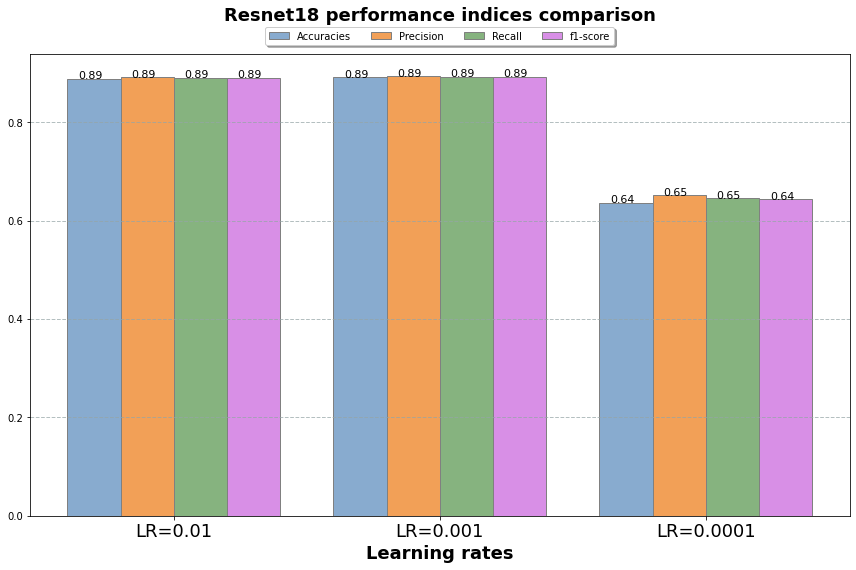

In [10]:
# Load the histogram plot of accuracy, recall, precision, f1-score
import pandas as pd

csv1_path = gdrivePath + "/CNN_finalMetrics/resnet" + "/resnet18_LR(0_01)_nEpochs(30)/metrics_LR(0_01)_nEpochs(30).csv"
csv2_path = gdrivePath + "/CNN_finalMetrics/resnet" + "/resnet18_LR(0_001)_nEpochs(30)/metrics_LR(0_001)_nEpochs(30).csv"
csv3_path = gdrivePath + "/CNN_finalMetrics/resnet" + "/resnet18_LR(0_0001)_nEpochs(30)/metrics_LR(0_0001)_nEpochs(30).csv"

csv1 = pd.read_csv(csv1_path, sep=';', engine='python')
csv2 = pd.read_csv(csv2_path, sep=';', engine='python')
csv3 = pd.read_csv(csv3_path, sep=';', engine='python')

barLabels = ["LR="+str(csv1['learning rate'].values[0]),"LR="+str(csv2['learning rate'].values[0]), \
             "LR="+str(csv3['learning rate'].values[0])]
accuracies = [csv1['accuracy'].values[0], csv2['accuracy'].values[0], csv3['accuracy'].values[0]]
precisions = [csv1['precision'].values[0], csv2['precision'].values[0], csv3['precision'].values[0]]
recalls = [csv1['recall'].values[0], csv2['recall'].values[0], csv3['recall'].values[0]]
f1scores = [csv1['f1-score'].values[0], csv2['f1-score'].values[0], csv3['f1-score'].values[0]]


[fig, ax] = create_4bars_chart(barLabels, dataY_1=accuracies, dataY_2=precisions,
              dataY_3=recalls, dataY_4=f1scores,
              labelsY=["Accuracies", "Precision", "Recall", "f1-score"],
              savingName=savingMetricsPath+("".join("ciao"))+"_acc_prec_rec_F1SCORE.jpg",
              title="Resnet18 performance indices comparison", plotLabelX="Learning rates", plotLabelY="")

# Save the histogram plot
plt.savefig(savingMetricsPath+"/performancesHistogram_differentLR"+".jpg")

